In [40]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.linear_model import LinearRegression

## Function to test independence of 2 random variables. 

Usage: 

`testStat, thresh = hsic_gam(X, Y, alph = 0.05)`

Independence test result
- If testStat < thresh, x and y are independent.
- If testStat > thresh, x and y are not independent.


In [42]:
"""
python implementation of Hilbert Schmidt Independence Criterion
hsic_gam implements the HSIC test using a Gamma approximation
Python 2.7.12
Gretton, A., Fukumizu, K., Teo, C. H., Song, L., Scholkopf, B., 
& Smola, A. J. (2007). A kernel statistical test of independence. 
In Advances in neural information processing systems (pp. 585-592).
Shoubo (shoubo.sub AT gmail.com)
https://github.com/amber0309/HSIC
09/11/2016
Inputs:
X n by dim_x matrix
Y n by dim_y matrix
alph level of test
Outputs:
testStat test statistics
thresh test threshold for level alpha test
"""

from __future__ import division
import numpy as np
from scipy.stats import gamma

def rbf_dot(pattern1, pattern2, deg):
    size1 = pattern1.shape
    size2 = pattern2.shape
    G = np.sum(pattern1*pattern1, 1).reshape(size1[0],1)
    H = np.sum(pattern2*pattern2, 1).reshape(size2[0],1)
    Q = np.tile(G, (1, size2[0]))
    R = np.tile(H.T, (size1[0], 1))
    H = Q + R - 2* np.dot(pattern1, pattern2.T)
    H = np.exp(-H/2/(deg**2))
    return H


def hsic_gam(X, Y, alph = 0.5):
    """
    X, Y are numpy vectors with row - sample, col - dim
    alph is the significance level
    auto choose median to be the kernel width
    """
    n = X.shape[0]
    # ----- width of X -----
    Xmed = X
    G = np.sum(Xmed*Xmed, 1).reshape(n,1)
    Q = np.tile(G, (1, n) )
    R = np.tile(G.T, (n, 1) )
    dists = Q + R - 2* np.dot(Xmed, Xmed.T)
    dists = dists - np.tril(dists)
    dists = dists.reshape(n**2, 1)
    width_x = np.sqrt( 0.5 * np.median(dists[dists>0]) )
    # ----- -----
    # ----- width of X -----
    Ymed = Y
    G = np.sum(Ymed*Ymed, 1).reshape(n,1)
    Q = np.tile(G, (1, n) )
    R = np.tile(G.T, (n, 1) )
    dists = Q + R - 2* np.dot(Ymed, Ymed.T)
    dists = dists - np.tril(dists)
    dists = dists.reshape(n**2, 1)
    width_y = np.sqrt( 0.5 * np.median(dists[dists>0]) )
    # ----- -----
    bone = np.ones((n, 1), dtype = float)
    H = np.identity(n) - np.ones((n,n), dtype = float) / n
    K = rbf_dot(X, X, width_x)
    L = rbf_dot(Y, Y, width_y)
    Kc = np.dot(np.dot(H, K), H)
    Lc = np.dot(np.dot(H, L), H)
    testStat = np.sum(Kc.T * Lc) / n
    varHSIC = (Kc * Lc / 6)**2
    varHSIC = ( np.sum(varHSIC) - np.trace(varHSIC) ) / n / (n-1)
    varHSIC = varHSIC * 72 * (n-4) * (n-5) / n / (n-1) / (n-2) / (n-3)
    K = K - np.diag(np.diag(K))
    L = L - np.diag(np.diag(L)) 
    muX = np.dot(np.dot(bone.T, K), bone) / n / (n-1)
    muY = np.dot(np.dot(bone.T, L), bone) / n / (n-1)
    mHSIC = (1 + muX * muY - muX - muY) / n
    al = mHSIC**2 / varHSIC
    bet = varHSIC*n / mHSIC
    thresh = gamma.ppf(1-alph, al, scale=bet)[0][0]
    return (testStat, thresh)

# Linear model $Y=bX+\epsilon$

## Gaussian distribution

Generate data

In [43]:
N = 1000
x = np.random.normal(0, 1, size=N)
#x = np.random.uniform(0, 1, size=N)
#x = np.random.laplace(loc=0.0, scale=1., size=N)
eps = np.random.normal(0, 1, size=N)
#eps = np.random.uniform(-0.5, 0.5, size=N)
#eps = np.random.laplace(loc=0.0, scale=0.5, size=N)
y = x + eps

Regress $Y$ on $X$

Text(0, 0.5, 'Y_residuals')

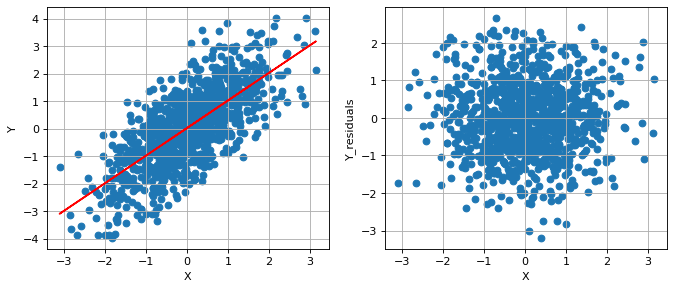

In [44]:
# build regression model
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(x.reshape(-1, 1),y)
y_pred = regressor.predict(x.reshape(-1, 1))

# plotting
figure(num=None, figsize=(10, 4), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(121)
plt.scatter(x=x, y=y)
plt.plot(x, y_pred, color="red")
plt.grid(True)
plt.xlabel("X")
plt.ylabel("Y")

# calculate the residuals and plot them
y_residuals = y_pred - y
plt.subplot(122)
plt.scatter(x=x, y=y_residuals)
plt.grid(True)
plt.xlabel("X")
plt.ylabel("Y_residuals")

Test independence

In [45]:
testStat, thresh = hsic_gam(X=x.reshape(-1, 1), Y=y_residuals.reshape(-1, 1), alph = 0.05)
print(testStat, thresh)
print("Independent: {}".format(testStat < thresh))

0.19005549564400637 0.5843204255657277
Independent: True


Regress $X$ on $Y$

Text(0, 0.5, 'X_residuals')

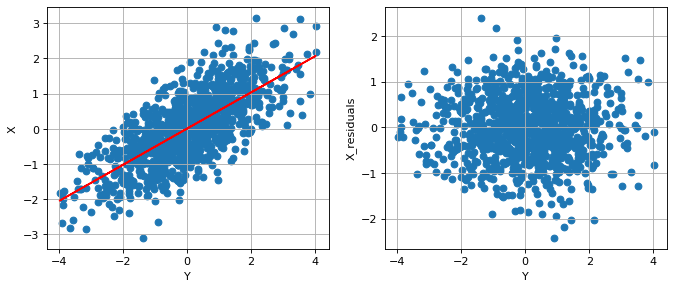

In [46]:
# build regression model
regressor.fit(y.reshape(-1, 1),x)
x_pred = regressor.predict(y.reshape(-1, 1))

# plotting
figure(num=None, figsize=(10, 4), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(121)
plt.scatter(x=y, y=x)
plt.plot(y, x_pred, color="red")
plt.grid(True)
plt.xlabel("Y")
plt.ylabel("X")

# calculate the residuals and plot them
x_residuals = x_pred - x
plt.subplot(122)
plt.scatter(x=y, y=x_residuals)
plt.grid(True)
plt.xlabel("Y")
plt.ylabel("X_residuals")

Test independence

In [47]:
testStat, thresh = hsic_gam(X=y.reshape(-1, 1), Y=x_residuals.reshape(-1, 1), alph = 0.05)
print(testStat, thresh)
print("Independent: {}".format(testStat < thresh))

0.11448835016061613 0.5841391632781914
Independent: True


## Exercise 1:
Try different distributions for $X$ and $\epsilon$ and fill the results in a table. What are your conclusions? Which cases are identifiable?

Note, you can use one type of distibution for $X$ and another type of distribution for $\epsilon$.

Distributions to use:
1. `np.random.normal`
2. `np.random.uniform`
3. `np.random.laplace`

In the cases that one of them is independent from residual and one of them is dependent to residuals, we can disregard the dependent one and take the independent one as the cause. 

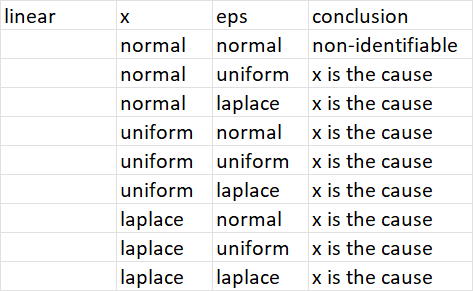

## Example of non-linear model $Y=bX^3+\epsilon$

Generate data

In [48]:
N = 1000
x = np.sort(np.random.normal(0, 1, size=N)) # sort X
#x = np.sort(np.random.uniform(-3, 3, size=N))
#x = np.sort(np.random.laplace(loc=0.0, scale=1., size=N))
eps = np.random.normal(0, 1, size=N)
#eps = np.random.uniform(-0.5, 0.5, size=N)
#eps = np.random.laplace(loc=0.0, scale=0.5, size=N)

y = x**3 + eps

Regress $Y$ on $X$

Text(0, 0.5, 'Y_residuals')

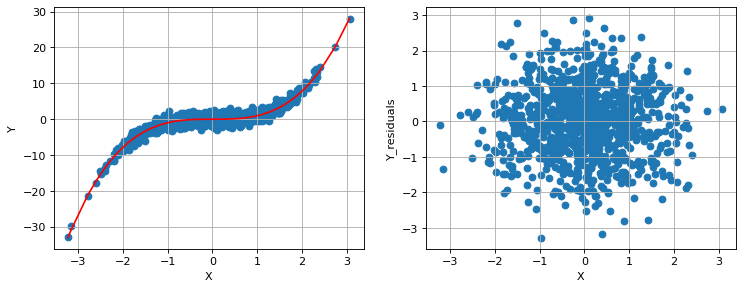

In [49]:
# build regression model
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
# transform X to use LinearRegression model
x_transform = x**3
regressor.fit(x_transform.reshape(-1, 1),y)
y_pred = regressor.predict(x_transform.reshape(-1, 1))

# plotting
figure(num=None, figsize=(11, 4), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(121)
plt.scatter(x=x, y=y)
#plt.scatter(x=x, y=y_pred, color="red")
plt.plot(x, y_pred, color="red")
plt.grid(True)
plt.xlabel("X")
plt.ylabel("Y")

# calculate the residuals and plot them
y_residuals = y_pred - y
plt.subplot(122)
plt.scatter(x=x, y=y_residuals)
plt.grid(True)
plt.xlabel("X")
plt.ylabel("Y_residuals")
#plt.xlabel("Y")
#plt.ylabel("X_residuals")

Test independence

In [50]:
testStat, thresh = hsic_gam(X=x.reshape(-1, 1), Y=y_residuals.reshape(-1, 1), alph = 0.05)
print(testStat, thresh)
print("Independent: {}".format(testStat < thresh))

0.2277892519879354 0.5808452120712819
Independent: True


Text(0, 0.5, 'X_residuals')

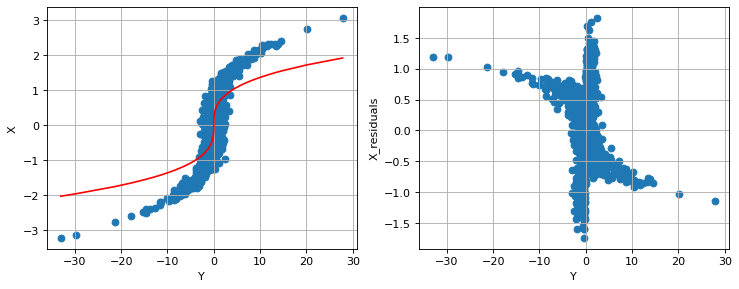

In [51]:
# build regression model
y_transform = np.cbrt(y)
regressor.fit(y_transform.reshape(-1, 1),x)
x_pred = regressor.predict(y_transform.reshape(-1, 1))

# plotting
figure(num=None, figsize=(11, 4), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(121)
plt.scatter(x=y, y=x)
# sort by y 
y_sorted, x_pred_sorted = zip(*sorted(zip(y, x_pred)))
y_sorted = list(y_sorted)
x_pred_sorted = list(x_pred_sorted)

plt.plot(y_sorted, x_pred_sorted, color="red")
plt.grid(True)
plt.xlabel("Y")
plt.ylabel("X")

# calculate the residuals and plot them
x_residuals = x_pred - x
plt.subplot(122)
plt.scatter(x=y, y=x_residuals)
plt.grid(True)
plt.xlabel("Y")
plt.ylabel("X_residuals")
#plt.xlabel("X")
#plt.ylabel("Y_residuals")

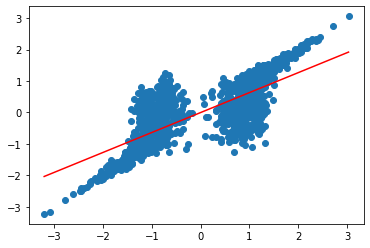

In [52]:
plt.scatter(y_transform, x)
plt.plot(y_transform, x_pred, color="red")

In [53]:
testStat, thresh = hsic_gam(X=y.reshape(-1, 1), Y=x_residuals.reshape(-1, 1), alph = 0.05)
print(testStat, thresh)
print("Independent: {}".format(testStat < thresh))

7.1923240610199795 0.5698339973449044
Independent: False


## Exercise 2

1. Try different distributions for $X$ and $\epsilon$ as in the previous assignment. Is there any case when we cannot identify causal direction?

answer: No there is no non-identifiable case, and in all of them x is the cause. According to the table below:

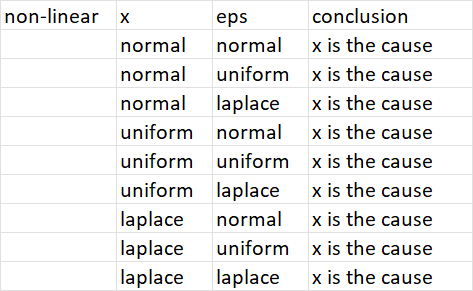

## Exercise 3

1. Perform similar tests for the model  $Y=f(X)+\epsilon$, where the corresponding function $f(X)$ is specified [here](https://docs.google.com/spreadsheets/d/1aS87yTukUsMIJcLMMaeuVKnzVLkhhU7m3wKfNyN2I6E/edit?usp=sharing). 
Adjust the variation of $X$ and $\epsilon$ if required.
2. For varying values of variance ranging from $var(X) / var(\epsilon) = 0.01$ to $var(X) / var(\epsilon) = 100$, estimate the accuracy of direction identification as a fraction of correct identifications in 30 independent runs. Plot the results. For which ranges we observe identifiability?

# 3.1

In [54]:
#Generate the data
N = 1000
#x = np.sort(np.random.normal(0, 1, size=N)) # sort X
#x = np.sort(np.random.uniform(-3, 3, size=N))
x = np.sort(np.random.laplace(loc=0.0, scale=1., size=N))
#eps = np.random.normal(0, 1, size=N)
#eps = np.random.uniform(-0.5, 0.5, size=N)
eps = np.random.laplace(loc=0.0, scale=0.5, size=N)

y = np.exp(x) + eps

Text(0, 0.5, 'Y_residuals')

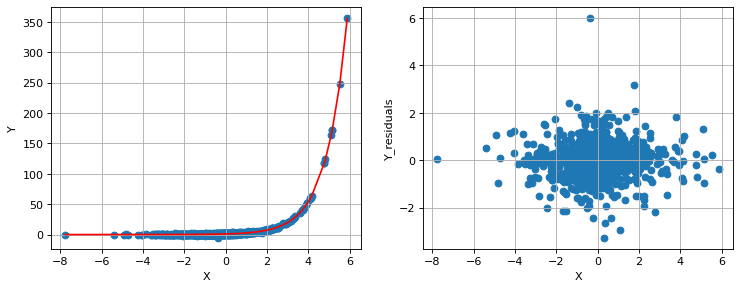

In [55]:
#Regress y on x
# build regression model
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
# transform X to use LinearRegression model
x_transform = np.exp(x)
regressor.fit(x_transform.reshape(-1, 1),y)
y_pred = regressor.predict(x_transform.reshape(-1, 1))

# plotting
figure(num=None, figsize=(11, 4), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(121)
plt.scatter(x=x, y=y)
#plt.scatter(x=x, y=y_pred, color="red")
plt.plot(x, y_pred, color="red")
plt.grid(True)
plt.xlabel("X")
plt.ylabel("Y")

# calculate the residuals and plot them
y_residuals = y_pred - y
plt.subplot(122)
plt.scatter(x=x, y=y_residuals)
plt.grid(True)
plt.xlabel("X")
plt.ylabel("Y_residuals")
#plt.xlabel("Y")
#plt.ylabel("X_residuals")

In [56]:
#test independence
testStat, thresh = hsic_gam(X=x.reshape(-1, 1), Y=y_residuals.reshape(-1, 1), alph = 0.05)
print(testStat, thresh)
print("Independent: {}".format(testStat < thresh))

0.38293371795390563 0.5386425214253614
Independent: True


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


Text(0, 0.5, 'X_residuals')

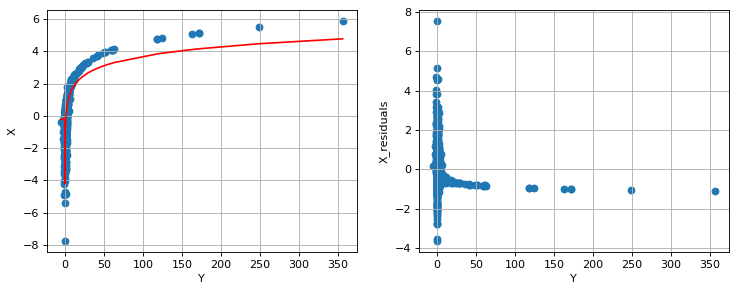

In [57]:
#regress x on y
y_transform = np.log(y) #log in numpy takes the natural log or Ln.
y_transform = np.nan_to_num(y_transform) #fills the NAs with numbers
regressor.fit(y_transform.reshape(-1, 1),x)
x_pred = regressor.predict(y_transform.reshape(-1, 1))

# plotting
figure(num=None, figsize=(11, 4), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(121)
plt.scatter(x=y, y=x)
# sort by y 
y_sorted, x_pred_sorted = zip(*sorted(zip(y, x_pred)))
y_sorted = list(y_sorted)
x_pred_sorted = list(x_pred_sorted)

plt.plot(y_sorted, x_pred_sorted, color="red")
plt.grid(True)
plt.xlabel("Y")
plt.ylabel("X")

# calculate the residuals and plot them
x_residuals = x_pred - x
plt.subplot(122)
plt.scatter(x=y, y=x_residuals)
plt.grid(True)
plt.xlabel("Y")
plt.ylabel("X_residuals")
#plt.xlabel("X")
#plt.ylabel("Y_residuals")

In [58]:
testStat, thresh = hsic_gam(X=y.reshape(-1, 1), Y=x_residuals.reshape(-1, 1), alph = 0.05)
print(testStat, thresh)
print("Independent: {}".format(testStat < thresh))

8.459890202773169 0.5266200869201237
Independent: False


The observations are like the table below:

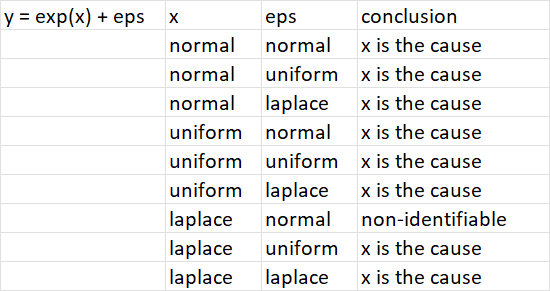

# 3.2

For this question I wrote 2 functions. The first function gets the distributions and the variance as inputs and gives arrays of x and eps with given distributions. The second function gets again the distributions and the variance as inputs and gives whether x and y are identifiable or not.

"GG" : x normal and eps normal

"GU" : x normal and eps uniform

"GL" : x normal and eps laplace

"UG" : x uniform and eps normal

"UU" : x uniform and eps uniform

"UL" : x uniform and eps laplace

"LG" : x laplace and eps normal

"LU" : x laplace and eps uniform

"LL" : x laplace and eps laplace


In [59]:
def dist(distributions,variance):
  if distributions == "GG":
    return [np.sort(np.random.normal(0, variance, size=N)),np.random.normal(0, variance, size=N)]
  elif distributions == "GU":
    return [np.sort(np.random.normal(0, variance, size=N)),np.random.uniform(-0.5, variance, size=N)]
  elif distributions == "GL":
    return [np.sort(np.random.normal(0, variance, size=N)),np.random.laplace(loc=0.0, scale=variance, size=N)]
  elif distributions == "UG":
    return [np.sort(np.random.uniform(-3,variance , size=N)),np.random.normal(0, variance, size=N)]  
  elif distributions == "UU":
    return [np.sort(np.random.uniform(-3,variance , size=N)),np.random.uniform(-0.5, variance, size=N)]  
  elif distributions == "UL":
    return [np.sort(np.random.uniform(-3,variance , size=N)),np.random.laplace(loc=0.0, scale=variance, size=N)]  
  elif distributions == "LG":
    return [np.sort(np.random.laplace(loc=0.0, scale=variance, size=N)),np.random.normal(0, variance, size=N)]  
  elif distributions == "LU":
    return [np.sort(np.random.laplace(loc=0.0, scale=variance, size=N)),np.random.uniform(-0.5, variance, size=N)]  
  elif distributions == "LL":
    return [np.sort(np.random.laplace(loc=0.0, scale=variance, size=N)),np.random.laplace(loc=0.0, scale=variance, size=N)]  

In [60]:
def ident(distribution,var):
  N = 1000
  x = dist(distribution,var)[0]
  eps = dist(distribution,var)[1]
  y = np.exp(x) + eps
  regressor = LinearRegression()
  # transform X to use LinearRegression model
  x_transform = np.exp(x)
  x_transform = np.nan_to_num(x_transform) #fills in the NAs
  regressor.fit(x_transform.reshape(-1, 1),y)
  y_pred = regressor.predict(x_transform.reshape(-1, 1))
  testStat1, thresh1 = hsic_gam(X=x.reshape(-1, 1), Y=y_residuals.reshape(-1, 1), alph = 0.05)
  y_transform = np.log(y) #log in numpy takes the natural log or Ln.
  y_transform = np.nan_to_num(y_transform) #fills the NAs with numbers
  regressor.fit(y_transform.reshape(-1, 1),x)
  x_pred = regressor.predict(y_transform.reshape(-1, 1))
  testStat2, thresh2 = hsic_gam(X=y.reshape(-1, 1), Y=x_residuals.reshape(-1, 1), alph = 0.05)
  if testStat1 < thresh1 and testStat2 < thresh2:
    return "non-identifiable"
  elif testStat1 < thresh1 and testStat2 >= thresh2:
    return "x is the cause"
  elif testStat1 >= thresh1 and testStat2 < thresh2:
    return "y is the cause"
  else:
    return "non-identifiable"  

In [61]:
ident("LU",0.1)

'x is the cause'

In [62]:
ident("UG",10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in log
  del sys.path[0]


'x is the cause'

In [63]:
ident("LG",75)

/usr/local/lib/python3.7/dist-packages/scipy/linalg/basic.py:1220: RuntimeWarning: overflow encountered in square
  resids = np.sum(np.abs(x[n:])**2, axis=0)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in log
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: RuntimeWarning: overflow encountered in multiply
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: RuntimeWarning: overflow encountered in multiply
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in subtract
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in subtract
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: overflow encountered in multiply
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in multiply
/usr/local/lib/p

'non-identifiable'

# Post-Additive models

## Exercise 4

1. Perform the same test as in Excercise 3 for the following model: $Y=(f(X)+\epsilon)^3$, where the corresponding function $f(X)$ is specified [here](https://docs.google.com/spreadsheets/d/1aS87yTukUsMIJcLMMaeuVKnzVLkhhU7m3wKfNyN2I6E/edit?usp=sharing). 
2. What are your conclusions from all exercises in this notebook?

In [64]:
#Generate the data
N = 1000
#x = np.sort(np.random.normal(0, 1, size=N)) # sort X
#x = np.sort(np.random.uniform(-3, 3, size=N))
x = np.sort(np.random.laplace(loc=0.0, scale=1., size=N))
#eps = np.random.normal(0, 1, size=N)
#eps = np.random.uniform(-0.5, 0.5, size=N)
eps = np.random.laplace(loc=0.0, scale=0.5, size=N)

y = (np.exp(x) + eps) ** 3

For x_transform I used this equation: 
(a+b)^3=a^3+b^3+3a^2b + 3ab^2


Text(0, 0.5, 'Y_residuals')

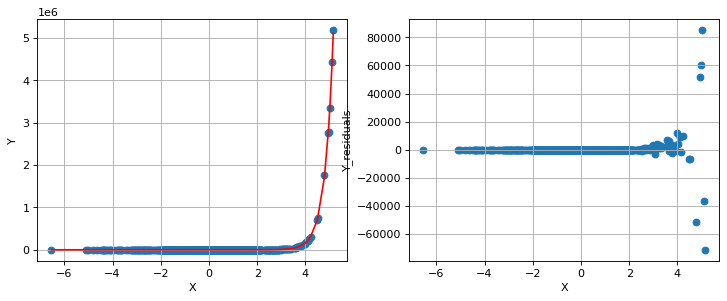

In [65]:
#Regress y on x
# build regression model
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
# transform X to use LinearRegression model
x_transform = ((np.exp(x)) ** 3) + (3*(np.exp(x)) ** 2) + (3*np.exp(x))
regressor.fit(x_transform.reshape(-1, 1),y)
y_pred = regressor.predict(x_transform.reshape(-1, 1))

# plotting
figure(num=None, figsize=(11, 4), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(121)
plt.scatter(x=x, y=y)
#plt.scatter(x=x, y=y_pred, color="red")
plt.plot(x, y_pred, color="red")
plt.grid(True)
plt.xlabel("X")
plt.ylabel("Y")

# calculate the residuals and plot them
y_residuals = y_pred - y
plt.subplot(122)
plt.scatter(x=x, y=y_residuals)
plt.grid(True)
plt.xlabel("X")
plt.ylabel("Y_residuals")
#plt.xlabel("Y")
#plt.ylabel("X_residuals")

In [66]:
#test independence
testStat, thresh = hsic_gam(X=x.reshape(-1, 1), Y=y_residuals.reshape(-1, 1), alph = 0.05)
print(testStat, thresh)
print("Independent: {}".format(testStat < thresh))

39.37734191603686 0.5525509957560273
Independent: False


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


Text(0, 0.5, 'X_residuals')

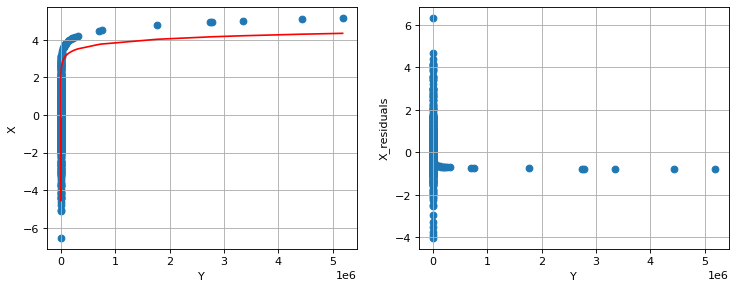

In [67]:
#regress x on y
y_transform = np.log(np.cbrt(y)) #log in numpy takes the natural log or Ln. here we take the log from y^1/3
y_transform = np.nan_to_num(y_transform) #fills the NAs with numbers
regressor.fit(y_transform.reshape(-1, 1),x)
x_pred = regressor.predict(y_transform.reshape(-1, 1))

# plotting
figure(num=None, figsize=(11, 4), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(121)
plt.scatter(x=y, y=x)
# sort by y 
y_sorted, x_pred_sorted = zip(*sorted(zip(y, x_pred)))
y_sorted = list(y_sorted)
x_pred_sorted = list(x_pred_sorted)

plt.plot(y_sorted, x_pred_sorted, color="red")
plt.grid(True)
plt.xlabel("Y")
plt.ylabel("X")

# calculate the residuals and plot them
x_residuals = x_pred - x
plt.subplot(122)
plt.scatter(x=y, y=x_residuals)
plt.grid(True)
plt.xlabel("Y")
plt.ylabel("X_residuals")
#plt.xlabel("X")
#plt.ylabel("Y_residuals")

In [68]:
testStat, thresh = hsic_gam(X=y.reshape(-1, 1), Y=x_residuals.reshape(-1, 1), alph = 0.05)
print(testStat, thresh)
print("Independent: {}".format(testStat < thresh))

6.801389240199611 0.4595360504377322
Independent: False


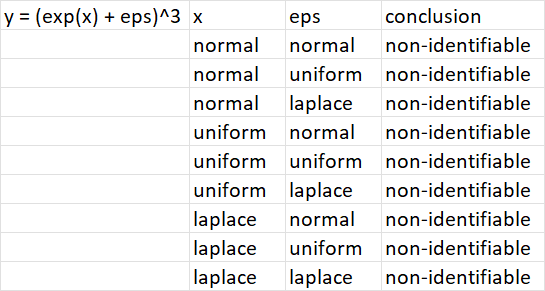

Conclusion: For orienting the edge between 2 variables we should write both x = F(y) + eps_x and y = F(x) + eps_y then if F(y) and eps_x are independent and F(x) and eps_y are not independent, y is the cause. If F(x) and eps_y are independent and F(y) and eps_x are dependent, x is the cause.If both are dependent or independent we cannot identify the orientation